# Performing sentiment analysis on the yelp reviews dataset using a fine-tuned DistilBERT model.

This notebook is an implementation of a sentiment analaysis performed on a cleaned version of the [Yelp dataset](https://huggingface.co/datasets/noahnsimbe/yelp-dataset). 
It contains model dvelopment, hyperparameter tuning, evaluation and analysis of performance. 

- [Information about the base model](https://huggingface.co/docs/transformers/model_doc/distilbert)
- [Information about ray use cases](https://docs.ray.io/en/latest/ray-overview/use-cases.html)
- [Ray tuning example](https://docs.ray.io/en/latest/train/examples/transformers/huggingface_text_classification.html)
- [Training](https://huggingface.co/docs/transformers/en/training)

## Installing required packages

In [1]:
! export RAY_PICKLE_VERBOSE_DEBUG='2'
! export RAY_AIR_NEW_OUTPUT='1'

In [2]:
! pip install -U datasets "transformers[torch]" "ray[tune]" evaluate scikit-learn seaborn

## Importing required packages

In [3]:
%%time
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline,
    AdamW,
    get_linear_schedule_with_warmup,
)
import numpy as np
from huggingface_hub import notebook_login
from ray import tune
import ray
import evaluate
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

CPU times: user 5.41 s, sys: 5.15 s, total: 10.6 s
Wall time: 31.6 s


In [4]:
base_model_checkpoint = "distilbert-base-uncased"
model_checkpoint = "noahnsimbe/DistilBERT-yelp-sentiment-analysis"
batch_size = 8
dataset_checkpoint = "noahnsimbe/yelp-dataset"
data_fraction = 0.001
num_train_epochs = 20

## Data Loading

In [5]:
%%time
data = load_dataset(dataset_checkpoint)

CPU times: user 146 ms, sys: 68.2 ms, total: 214 ms
Wall time: 7.53 s


### Using a fraction of the data

In [6]:
train_data = data["train"].train_test_split(train_size=data_fraction)["train"]
test_data = data["test"].train_test_split(train_size=data_fraction)["train"]
eval_data = data["eval"].train_test_split(train_size=data_fraction)["train"]

## Data Preprocessing

### Creating tokenizer from the pre-trained DistilBERT model

In [7]:
tokenizer = AutoTokenizer.from_pretrained(base_model_checkpoint)

In [8]:
def preprocess_function(review):
    """
    Tokenizes the text in a given record using the tokenizer with truncation.

    Args:
        record (dict): A dictionary containing the text to be tokenized under the key "text".

    Returns:
        dict: A dictionary containing the tokenized text.
    """
    return tokenizer(review["text"], truncation=True)

### Tokenize the text using the tokenizer with truncation

In [9]:
%%time
tokenized_train_data = train_data.map(preprocess_function, batched=True)
tokenized_test_data = test_data.map(preprocess_function, batched=True)
tokenized_eval_data = eval_data.map(preprocess_function, batched=True)

train_dataset = Dataset.from_list(tokenized_train_data)
test_dataset = Dataset.from_list(tokenized_test_data)
eval_dataset = Dataset.from_list(tokenized_eval_data)

Map:   0%|          | 0/123 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

CPU times: user 177 ms, sys: 38.4 ms, total: 215 ms
Wall time: 392 ms


### Creating the DataCollatorWithPadding object

In [10]:
%%time

# Converts the training samples to PyTorch tensors and concatenate them with the correct amount of padding to speed up training
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

CPU times: user 8 µs, sys: 7 µs, total: 15 µs
Wall time: 18.6 µs


## Model Development

### Load pre-trained model for sequence classification

In [11]:
%%time
model = AutoModelForSequenceClassification.from_pretrained(
    base_model_checkpoint, num_labels=3
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 3.55 s, sys: 214 ms, total: 3.76 s
Wall time: 6.26 s


### Define the metrics to evaluate the model

In [12]:
def compute_metrics(eval_pred):
    """
    Compute various evaluation metrics such as accuracy, F1 score, precision, and recall.

    Args:
        eval_pred (tuple): A tuple containing the model predictions (logits) and the ground truth labels.

    Returns:
        dict: A dictionary containing computed evaluation metrics (accuracy, F1 score, precision, and recall).
    """
        
    load_accuracy = evaluate.load("accuracy", trust_remote_code=True)
    load_f1 = evaluate.load("f1", trust_remote_code=True)
    load_precision = evaluate.load("precision", trust_remote_code=True)
    load_recall = evaluate.load("recall", trust_remote_code=True)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)[
        "accuracy"
    ]
    f1 = load_f1.compute(predictions=predictions, references=labels, average="macro")[
        "f1"
    ]
    precision = load_precision.compute(
        predictions=predictions, references=labels, average="macro", zero_division=0
    )["precision"]
    recall = load_recall.compute(
        predictions=predictions, references=labels, average="macro"
    )["recall"]
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

### Define training arguments for the model training process

In [13]:
training_args = TrainingArguments(
    output_dir=model_checkpoint,
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    push_to_hub=False,
    use_cpu=True,
)

### Define the optimizer and learning rate scheduler

In [14]:
optimizer = AdamW(model.parameters(), lr=5e-5)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataset) * training_args.num_train_epochs,
)

/home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Define the Trainer for model training

In [15]:
model_trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    optimizers=(optimizer, lr_scheduler),
)

/home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


### Train the model

In [15]:
%%time
model_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.741474,0.772727,0.475181,0.547159,0.469048
2,No log,0.621551,0.831169,0.564286,0.554622,0.576720
3,No log,0.598163,0.824675,0.611489,0.654660,0.588055
4,0.469600,1.017418,0.759740,0.591637,0.628205,0.578775
5,0.469600,1.144807,0.798701,0.647619,0.670467,0.648840
6,0.469600,1.458501,0.772727,0.609871,0.652370,0.611803
7,0.137400,1.531086,0.766234,0.632618,0.664260,0.649349
8,0.137400,1.637585,0.766234,0.621907,0.653630,0.626882
9,0.137400,1.809254,0.746753,0.604940,0.647822,0.611274
10,0.035200,1.762039,0.792208,0.629265,0.672858,0.627411


CPU times: user 6h 41min 9s, sys: 11min 57s, total: 6h 53min 6s
Wall time: 38min 31s


TrainOutput(global_step=3100, training_loss=0.11718650702507265, metrics={'train_runtime': 2310.9176, 'train_samples_per_second': 10.68, 'train_steps_per_second': 1.341, 'total_flos': 1049062189909320.0, 'train_loss': 0.11718650702507265, 'epoch': 20.0})

## Model Evaluation

### Evalute the model

In [16]:
%%time
model_trainer.evaluate(eval_dataset=eval_dataset)

CPU times: user 39.5 s, sys: 27.8 ms, total: 39.5 s
Wall time: 5.47 s


{'eval_loss': 0.49699991941452026,
 'eval_accuracy': 0.8181818181818182,
 'eval_f1': 0.6751528174574105,
 'eval_precision': 0.7146135265700483,
 'eval_recall': 0.6491336903051673,
 'eval_runtime': 5.4462,
 'eval_samples_per_second': 28.277,
 'eval_steps_per_second': 3.672,
 'epoch': 20.0}

In [17]:
model_pipeline = pipeline("text-classification", model=model_trainer.model, tokenizer=tokenizer)

In [26]:
predictions = model_pipeline(eval_dataset["text"])
y_test = eval_dataset["label"]

In [27]:
label_mapping = {
    'LABEL_0': 0,
    'LABEL_1': 1,
    'LABEL_2': 2
}
class_labels = ["Negative", "Neutral", "Positive"]

### Generate predictions and evaluation metrics.

In [29]:
y_pred = list(map(lambda x: label_mapping[x['label']], predictions))
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=class_labels)

### Classification report

In [30]:
print(f"Classification Report:\n{classification_rep}")

Classification Report:
              precision    recall  f1-score   support

    Negative       0.96      0.74      0.84        31
     Neutral       0.33      0.26      0.29        19
    Positive       0.85      0.94      0.89       104

    accuracy                           0.82       154
   macro avg       0.71      0.65      0.68       154
weighted avg       0.81      0.82      0.81       154



### Confusion Matrix

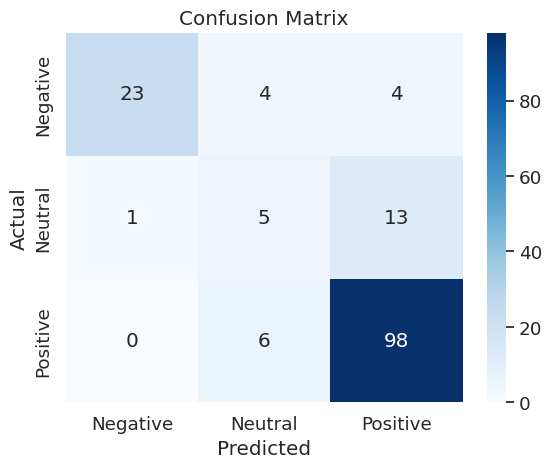

In [31]:
sns.set(font_scale=1.2)
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Observation

Based on this analysis, the model performs well overall, with high precision, recall, and F1-score for Negative and Positive sentiments. However, the performance for Neutral sentiment is relatively lower, with lower precision, recall, and F1-score.

## Hyperparameter Tuning

In [16]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        base_model_checkpoint, num_labels=3, return_dict=True
    )

In [17]:
hp_trainer = Trainer(
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    model_init=model_init,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
def ray_hp_space(_):
    return {
        "learning_rate": tune.loguniform(1e-6, 1e-4),
        "per_device_train_batch_size": tune.choice([4, 8, 16]),
        "per_device_eval_batch_size": tune.choice([4, 8, 16]),
        "weight_decay": tune.choice([0.001, 0.01, 0.1]),
        "num_train_epochs": tune.choice([5, 10, 15, 20]),
    }

In [19]:
%%time
ray.init(num_cpus=24, num_gpus=0, resources={"special_hardware": 1, "custom_label": 1})
results = hp_trainer.hyperparameter_search(
    direction="maximize",
    backend="ray",
    hp_space=ray_hp_space,
    resources_per_trial={"cpu": 12},
    n_trials=4,
)
ray.shutdown()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

== Status ==
Current time: 2024-04-14 20:37:00 (running for 00:00:00.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (4 PENDING)
+------------------------+----------+-------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc   |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |       |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+-------+-----------------+--------------------+------------------------+------------------------+----------------|
| _objective_

(_objective pid=39173) /home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
(_objective pid=39173) dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
(_objective pid=39173)   warnings.warn(
(_objective pid=39168) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
(_objective pid=39168) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|        

== Status ==
Current time: 2024-04-14 20:37:10 (running for 00:00:10.31)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+-

  1%|          | 5/620 [00:04<10:14,  1.00it/s]
(_objective pid=39168) /home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
(_objective pid=39168) dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
(_objective pid=39168)   warnings.warn(
(_objective pid=39173) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
(_objective pid=39173) You should probably TRAIN this model on a down-stream task to be able to use

== Status ==
Current time: 2024-04-14 20:37:15 (running for 00:00:15.38)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+-

  2%|▏         | 14/620 [00:11<07:51,  1.29it/s] [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


== Status ==
Current time: 2024-04-14 20:37:20 (running for 00:00:20.46)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+-

  3%|▎         | 21/620 [00:16<06:28,  1.54it/s] [repeated 8x across cluster]


== Status ==
Current time: 2024-04-14 20:37:25 (running for 00:00:25.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+-

  5%|▍         | 29/620 [00:22<07:07,  1.38it/s] [repeated 9x across cluster]


== Status ==
Current time: 2024-04-14 20:37:30 (running for 00:00:30.63)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+-

(_objective pid=39168) 
  0%|          | 0/1 [00:00<?, ?it/s]
                                                
100%|██████████| 1/1 [00:02<00:00,  2.61s/it]
                                             
  6%|▌         | 7/120 [00:26<05:35,  2.97s/it] [repeated 5x across cluster]


(_objective pid=39168) {'eval_loss': 1.0132845640182495, 'eval_accuracy': 0.4666666666666667, 'eval_f1': 0.21212121212121213, 'eval_precision': 0.15555555555555556, 'eval_recall': 0.3333333333333333, 'eval_runtime': 3.4306, 'eval_samples_per_second': 4.372, 'eval_steps_per_second': 0.291, 'epoch': 1.0}
== Status ==
Current time: 2024-04-14 20:37:35 (running for 00:00:35.70)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat

Trial name
_objective_be5cf_00000
_objective_be5cf_00001
_objective_be5cf_00002
_objective_be5cf_00003


(_objective pid=39168) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ayepwebsite/ray_results/_objective_2024-04-14_20-37-00/_objective_be5cf_00000_0_learning_rate=0.0000,num_train_epochs=20,per_device_eval_batch_size=16,per_device_train_batch_size=4,weig_2024-04-14_20-37-00/checkpoint_000000)
  7%|▋         | 8/120 [00:30<04:48,  2.57s/it]
                                             
  5%|▌         | 33/620 [00:32<21:22,  2.19s/it] [repeated 3x across cluster]


== Status ==
Current time: 2024-04-14 20:37:40 (running for 00:00:40.73)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-----

(_objective pid=39173) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ayepwebsite/ray_results/_objective_2024-04-14_20-37-00/_objective_be5cf_00001_1_learning_rate=0.0000,num_train_epochs=15,per_device_eval_batch_size=8,per_device_train_batch_size=16,weig_2024-04-14_20-37-00/checkpoint_000000)
  7%|▋         | 43/620 [00:38<06:27,  1.49it/s] [repeated 11x across cluster]


== Status ==
Current time: 2024-04-14 20:37:45 (running for 00:00:45.80)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-----

  8%|▊         | 50/620 [00:43<06:49,  1.39it/s] [repeated 9x across cluster]


== Status ==
Current time: 2024-04-14 20:37:50 (running for 00:00:50.83)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-----

 11%|█         | 13/120 [00:48<06:14,  3.50s/it] [repeated 9x across cluster]


== Status ==
Current time: 2024-04-14 20:38:01 (running for 00:01:00.98)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-----

 10%|█         | 62/620 [00:53<09:37,  1.04s/it] [repeated 6x across cluster]
(_objective pid=39168) 
  0%|          | 0/1 [00:00<?, ?it/s]
                                                
100%|██████████| 1/1 [00:02<00:00,  2.48s/it]
                                             


(_objective pid=39168) {'eval_loss': 1.0108739137649536, 'eval_accuracy': 0.4666666666666667, 'eval_f1': 0.21212121212121213, 'eval_precision': 0.15555555555555556, 'eval_recall': 0.3333333333333333, 'eval_runtime': 3.6237, 'eval_samples_per_second': 4.139, 'eval_steps_per_second': 0.276, 'epoch': 2.0} [repeated 2x across cluster]
== Status ==
Current time: 2024-04-14 20:38:06 (running for 00:01:06.05)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   pe

(_objective pid=39168) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ayepwebsite/ray_results/_objective_2024-04-14_20-37-00/_objective_be5cf_00000_0_learning_rate=0.0000,num_train_epochs=20,per_device_eval_batch_size=16,per_device_train_batch_size=4,weig_2024-04-14_20-37-00/checkpoint_000001)
 13%|█▎        | 16/120 [00:59<06:37,  3.82s/it]
(_objective pid=39173) 
  0%|          | 0/2 [00:00<?, ?it/s]
(_objective pid=39173) 
100%|██████████| 2/2 [00:00<00:00,  4.72it/s]
                                                
100%|██████████| 2/2 [00:02<00:00,  4.72it/s]
                                             


(_objective pid=39173) {'eval_loss': 1.0144450664520264, 'eval_accuracy': 0.4666666666666667, 'eval_f1': 0.21212121212121213, 'eval_precision': 0.15555555555555556, 'eval_recall': 0.3333333333333333, 'eval_runtime': 3.013, 'eval_samples_per_second': 4.978, 'eval_steps_per_second': 0.664, 'epoch': 2.0}
== Status ==
Current time: 2024-04-14 20:38:11 (running for 00:01:11.14)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_dev

 11%|█         | 68/620 [01:05<09:38,  1.05s/it] [repeated 6x across cluster]
(raylet) [2024-04-14 20:38:13,222 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 7774777344; capacity: 155897610240. Object creation will fail if spilling is required.
(_objective pid=39173) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ayepwebsite/ray_results/_objective_2024-04-14_20-37-00/_objective_be5cf_00001_1_learning_rate=0.0000,num_train_epochs=15,per_device_eval_batch_size=8,per_device_train_batch_size=16,weig_2024-04-14_20-37-00/checkpoint_000001)


== Status ==
Current time: 2024-04-14 20:38:16 (running for 00:01:16.21)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-----

 12%|█▏        | 76/620 [01:10<06:56,  1.31it/s] [repeated 8x across cluster]


== Status ==
Current time: 2024-04-14 20:38:21 (running for 00:01:21.30)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-----

 14%|█▎        | 84/620 [01:15<05:25,  1.65it/s] [repeated 8x across cluster]
(raylet) [2024-04-14 20:38:23,239 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 7717302272; capacity: 155897610240. Object creation will fail if spilling is required.


== Status ==
Current time: 2024-04-14 20:38:26 (running for 00:01:26.37)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-----

 14%|█▍        | 89/620 [01:20<07:57,  1.11it/s] [repeated 7x across cluster]
(_objective pid=39168) 
  0%|          | 0/1 [00:00<?, ?it/s]


== Status ==
Current time: 2024-04-14 20:38:31 (running for 00:01:31.45)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-----

(raylet) [2024-04-14 20:38:33,264 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 7717298176; capacity: 155897610240. Object creation will fail if spilling is required.
 17%|█▋        | 20/120 [01:24<07:06,  4.27s/it] [repeated 6x across cluster]
                                                
100%|██████████| 1/1 [00:02<00:00,  2.41s/it]
                                             


(_objective pid=39168) {'eval_loss': 1.014366865158081, 'eval_accuracy': 0.4666666666666667, 'eval_f1': 0.21212121212121213, 'eval_precision': 0.15555555555555556, 'eval_recall': 0.3333333333333333, 'eval_runtime': 3.1986, 'eval_samples_per_second': 4.69, 'eval_steps_per_second': 0.313, 'epoch': 3.0}


(_objective pid=39168) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ayepwebsite/ray_results/_objective_2024-04-14_20-37-00/_objective_be5cf_00000_0_learning_rate=0.0000,num_train_epochs=20,per_device_eval_batch_size=16,per_device_train_batch_size=4,weig_2024-04-14_20-37-00/checkpoint_000002)


== Status ==
Current time: 2024-04-14 20:38:36 (running for 00:01:36.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-----

 15%|█▌        | 96/620 [01:31<13:24,  1.54s/it] [repeated 5x across cluster]


== Status ==
Current time: 2024-04-14 20:38:41 (running for 00:01:41.58)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-----

(raylet) [2024-04-14 20:38:43,281 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 6108172288; capacity: 155897610240. Object creation will fail if spilling is required.
 20%|██        | 24/120 [01:36<05:10,  3.24s/it] [repeated 8x across cluster]
(_objective pid=39173) 
  0%|          | 0/2 [00:00<?, ?it/s]
(_objective pid=39173) 
100%|██████████| 2/2 [00:00<00:00,  5.25it/s]
                                                
100%|██████████| 2/2 [00:02<00:00,  5.25it/s]
                                             


(_objective pid=39173) {'eval_loss': 1.0209242105484009, 'eval_accuracy': 0.4666666666666667, 'eval_f1': 0.21212121212121213, 'eval_precision': 0.15555555555555556, 'eval_recall': 0.3333333333333333, 'eval_runtime': 2.7216, 'eval_samples_per_second': 5.511, 'eval_steps_per_second': 0.735, 'epoch': 3.0}
== Status ==
Current time: 2024-04-14 20:38:46 (running for 00:01:46.65)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_de

 18%|█▊        | 110/620 [01:42<07:14,  1.17it/s] [repeated 8x across cluster]
(_objective pid=39173) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ayepwebsite/ray_results/_objective_2024-04-14_20-37-00/_objective_be5cf_00001_1_learning_rate=0.0000,num_train_epochs=15,per_device_eval_batch_size=8,per_device_train_batch_size=16,weig_2024-04-14_20-37-00/checkpoint_000002)


== Status ==
Current time: 2024-04-14 20:38:51 (running for 00:01:51.67)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-----

(raylet) [2024-04-14 20:38:53,301 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 4498997248; capacity: 155897610240. Object creation will fail if spilling is required.
 19%|█▉        | 117/620 [01:47<07:44,  1.08it/s] [repeated 8x across cluster]


== Status ==
Current time: 2024-04-14 20:38:56 (running for 00:01:56.74)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-----

(_objective pid=39168) 
 20%|██        | 124/620 [01:51<04:57,  1.67it/s] [repeated 8x across cluster]


== Status ==
Current time: 2024-04-14 20:39:01 (running for 00:02:01.83)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-----

                                                 
100%|██████████| 1/1 [00:02<00:00,  2.46s/it]
                                             


(_objective pid=39168) {'eval_loss': 0.987764298915863, 'eval_accuracy': 0.4666666666666667, 'eval_f1': 0.21212121212121213, 'eval_precision': 0.15555555555555556, 'eval_recall': 0.3333333333333333, 'eval_runtime': 3.2486, 'eval_samples_per_second': 4.617, 'eval_steps_per_second': 0.308, 'epoch': 4.0}


(raylet) [2024-04-14 20:39:03,319 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 4207542272; capacity: 155897610240. Object creation will fail if spilling is required.
(_objective pid=39168) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ayepwebsite/ray_results/_objective_2024-04-14_20-37-00/_objective_be5cf_00000_0_learning_rate=0.0000,num_train_epochs=20,per_device_eval_batch_size=16,per_device_train_batch_size=4,weig_2024-04-14_20-37-00/checkpoint_000003)
 22%|██▎       | 27/120 [01:53<06:27,  4.17s/it]


== Status ==
Current time: 2024-04-14 20:39:06 (running for 00:02:06.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-----

 20%|██        | 126/620 [02:01<19:50,  2.41s/it]


== Status ==
Current time: 2024-04-14 20:39:12 (running for 00:02:11.97)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-----

 21%|██▏       | 133/620 [02:05<06:13,  1.30it/s] [repeated 9x across cluster]
(raylet) [2024-04-14 20:39:13,337 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 2889785344; capacity: 155897610240. Object creation will fail if spilling is required.


== Status ==
Current time: 2024-04-14 20:39:17 (running for 00:02:17.04)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-----

 22%|██▏       | 139/620 [02:11<06:16,  1.28it/s] [repeated 7x across cluster]
(_objective pid=39173) 
  0%|          | 0/2 [00:00<?, ?it/s]
(_objective pid=39173) 
100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


== Status ==
Current time: 2024-04-14 20:39:22 (running for 00:02:22.14)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-----

                                                
100%|██████████| 2/2 [00:02<00:00,  5.79it/s]
                                             


(_objective pid=39173) {'eval_loss': 0.9631567597389221, 'eval_accuracy': 0.4666666666666667, 'eval_f1': 0.21212121212121213, 'eval_precision': 0.15555555555555556, 'eval_recall': 0.3333333333333333, 'eval_runtime': 3.0325, 'eval_samples_per_second': 4.946, 'eval_steps_per_second': 0.66, 'epoch': 4.0}


(raylet) [2024-04-14 20:39:23,354 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 2682359808; capacity: 155897610240. Object creation will fail if spilling is required.
 24%|██▎       | 146/620 [02:15<05:43,  1.38it/s] [repeated 9x across cluster]
(_objective pid=39173) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ayepwebsite/ray_results/_objective_2024-04-14_20-37-00/_objective_be5cf_00001_1_learning_rate=0.0000,num_train_epochs=15,per_device_eval_batch_size=8,per_device_train_batch_size=16,weig_2024-04-14_20-37-00/checkpoint_000003)


== Status ==
Current time: 2024-04-14 20:39:27 (running for 00:02:27.19)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-----

 25%|██▌       | 155/620 [02:21<06:23,  1.21it/s] [repeated 9x across cluster]
(_objective pid=39168) 
  0%|          | 0/1 [00:00<?, ?it/s]
                                                 
100%|██████████| 1/1 [00:02<00:00,  2.09s/it]
                                             


(_objective pid=39168) {'eval_loss': 0.901655912399292, 'eval_accuracy': 0.5333333333333333, 'eval_f1': 0.3586744639376218, 'eval_precision': 0.38888888888888884, 'eval_recall': 0.3968253968253968, 'eval_runtime': 2.841, 'eval_samples_per_second': 5.28, 'eval_steps_per_second': 0.352, 'epoch': 5.0}
== Status ==
Current time: 2024-04-14 20:39:32 (running for 00:02:32.27)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device

(raylet) [2024-04-14 20:39:33,371 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 854532096; capacity: 155897610240. Object creation will fail if spilling is required.
 29%|██▉       | 35/120 [02:28<05:49,  4.11s/it] [repeated 3x across cluster]
2024-04-14 20:39:36,278	ERROR tune_controller.py:1332 -- Trial task failed for trial _objective_be5cf_00000
Traceback (most recent call last):
  File "/home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ayepwebsite/ad-dl/venv/lib

== Status ==
Current time: 2024-04-14 20:39:37 (running for 00:02:37.35)
Using FIFO scheduling algorithm.
Logical resource usage: 12.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (1 ERROR, 2 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+--------------

(raylet) [2024-04-14 20:39:43,391 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 806825984; capacity: 155897610240. Object creation will fail if spilling is required.
 31%|███       | 37/120 [02:31<04:00,  2.89s/it] [repeated 2x across cluster]
(_objective pid=39660) /home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
(_objective pid=39660) dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
(_objective pid=39660)   warnings.warn(


== Status ==
Current time: 2024-04-14 20:39:47 (running for 00:02:47.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (1 ERROR, 1 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+--------------

 33%|███▎      | 40/120 [02:43<04:04,  3.06s/it] [repeated 3x across cluster]
(_objective pid=39173) 
  0%|          | 0/2 [00:00<?, ?it/s]
(_objective pid=39173) 
100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


== Status ==
Current time: 2024-04-14 20:39:52 (running for 00:02:52.56)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (1 ERROR, 1 PENDING, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+--------------

                                                
100%|██████████| 2/2 [00:02<00:00,  5.71it/s]
                                             


(_objective pid=39173) {'eval_loss': 0.9388664960861206, 'eval_accuracy': 0.4666666666666667, 'eval_f1': 0.21212121212121213, 'eval_precision': 0.15555555555555556, 'eval_recall': 0.3333333333333333, 'eval_runtime': 2.925, 'eval_samples_per_second': 5.128, 'eval_steps_per_second': 0.684, 'epoch': 5.0}


(raylet) [2024-04-14 20:39:53,412 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 713134080; capacity: 155897610240. Object creation will fail if spilling is required.
2024-04-14 20:39:56,578	ERROR tune_controller.py:1332 -- Trial task failed for trial _objective_be5cf_00001
Traceback (most recent call last):
  File "/home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/ray/_private/worker.py", line 2667, in get
    values

== Status ==
Current time: 2024-04-14 20:39:57 (running for 00:02:57.65)
Using FIFO scheduling algorithm.
Logical resource usage: 12.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 ERROR, 1 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+--------------

(raylet) [2024-04-14 20:40:03,433 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 806637568; capacity: 155897610240. Object creation will fail if spilling is required.
(_objective pid=39816) /home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
(_objective pid=39816) dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
(_objective pid=39816)   warnings.warn(
(_objective pid=39816) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and ar

== Status ==
Current time: 2024-04-14 20:40:07 (running for 00:03:07.77)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 ERROR, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-------

  1%|          | 3/320 [00:06<10:56,  2.07s/it]


== Status ==
Current time: 2024-04-14 20:40:12 (running for 00:03:12.83)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 ERROR, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-------

(raylet) [2024-04-14 20:40:13,451 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 806518784; capacity: 155897610240. Object creation will fail if spilling is required.
  2%|▏         | 7/320 [00:10<06:24,  1.23s/it]


== Status ==
Current time: 2024-04-14 20:40:17 (running for 00:03:17.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 ERROR, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-------

  3%|▎         | 9/320 [00:16<09:49,  1.89s/it]


== Status ==
Current time: 2024-04-14 20:40:23 (running for 00:03:22.96)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 ERROR, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-------

  3%|▎         | 10/320 [00:17<08:20,  1.62s/it]
(raylet) [2024-04-14 20:40:23,471 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 806514688; capacity: 155897610240. Object creation will fail if spilling is required.
  4%|▍         | 14/320 [00:21<06:39,  1.30s/it]


== Status ==
Current time: 2024-04-14 20:40:28 (running for 00:03:28.02)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 ERROR, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-------

  5%|▌         | 16/320 [00:24<06:13,  1.23s/it]
(_objective pid=39816) 
  0%|          | 0/2 [00:00<?, ?it/s]
(_objective pid=39816) 
100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


== Status ==
Current time: 2024-04-14 20:40:33 (running for 00:03:33.09)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (2 ERROR, 2 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-------

                                                
100%|██████████| 2/2 [00:02<00:00,  5.56it/s]
                                             
(raylet) [2024-04-14 20:40:33,493 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 806502400; capacity: 155897610240. Object creation will fail if spilling is required.
2024-04-14 20:40:37,721	ERROR tune_controller.py:1332 -- Trial task failed for trial _objective_be5cf_00003
Traceback (most recent call last):
  File "/home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return

== Status ==
Current time: 2024-04-14 20:40:38 (running for 00:03:38.18)
Using FIFO scheduling algorithm.
Logical resource usage: 12.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (3 ERROR, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-------

(raylet) [2024-04-14 20:40:43,515 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 806440960; capacity: 155897610240. Object creation will fail if spilling is required.


== Status ==
Current time: 2024-04-14 20:40:48 (running for 00:03:48.31)
Using FIFO scheduling algorithm.
Logical resource usage: 12.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (3 ERROR, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-------

(raylet) [2024-04-14 20:40:53,537 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 806445056; capacity: 155897610240. Object creation will fail if spilling is required.


== Status ==
Current time: 2024-04-14 20:40:58 (running for 00:03:58.43)
Using FIFO scheduling algorithm.
Logical resource usage: 12.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (3 ERROR, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-------

(_objective pid=39660) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
(_objective pid=39660) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  4%|▍         | 6/155 [00:04<01:29,  1.66it/s]


== Status ==
Current time: 2024-04-14 20:41:03 (running for 00:04:03.49)
Using FIFO scheduling algorithm.
Logical resource usage: 12.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (3 ERROR, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-------

(raylet) [2024-04-14 20:41:03,558 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 806383616; capacity: 155897610240. Object creation will fail if spilling is required.
 10%|▉         | 15/155 [00:09<01:52,  1.25it/s]


== Status ==
Current time: 2024-04-14 20:41:08 (running for 00:04:08.56)
Using FIFO scheduling algorithm.
Logical resource usage: 12.0/24 CPUs, 0/0 GPUs (0.0/1.0 special_hardware, 0.0/1.0 custom_label)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (3 ERROR, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-------

 19%|█▊        | 29/155 [00:13<00:42,  2.99it/s]
(raylet) [2024-04-14 20:41:13,575 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 806375424; capacity: 155897610240. Object creation will fail if spilling is required.
 19%|█▉        | 30/155 [00:14<00:49,  2.52it/s]


== Status ==
Current time: 2024-04-14 20:41:13 (running for 00:04:13.61)
Using FIFO scheduling algorithm.
Logical resource usage: 12.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (3 ERROR, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-------

 20%|██        | 31/155 [00:14<00:47,  2.60it/s]
(_objective pid=39660) 
  0%|          | 0/1 [00:00<?, ?it/s]
                                                
100%|██████████| 1/1 [00:02<00:00,  2.57s/it]
                                             


(_objective pid=39660) {'eval_loss': 1.0792505741119385, 'eval_accuracy': 0.4666666666666667, 'eval_f1': 0.21212121212121213, 'eval_precision': 0.15555555555555556, 'eval_recall': 0.3333333333333333, 'eval_runtime': 2.8915, 'eval_samples_per_second': 5.188, 'eval_steps_per_second': 0.346, 'epoch': 1.0}
== Status ==
Current time: 2024-04-14 20:41:18 (running for 00:04:18.65)
Using FIFO scheduling algorithm.
Logical resource usage: 12.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (3 ERROR, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_devi

(raylet) [2024-04-14 20:41:23,590 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 187871232; capacity: 155897610240. Object creation will fail if spilling is required.


== Status ==
Current time: 2024-04-14 20:41:23 (running for 00:04:23.73)
Using FIFO scheduling algorithm.
Logical resource usage: 12.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (3 ERROR, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+-------

2024-04-14 20:41:29,390	ERROR tune_controller.py:1332 -- Trial task failed for trial _objective_be5cf_00002
Traceback (most recent call last):
  File "/home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/ray/_private/worker.py", line 2667, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/ray/_private/worker.py", line 864, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(OSE

== Status ==
Current time: 2024-04-14 20:41:29 (running for 00:04:29.34)
Using FIFO scheduling algorithm.
Logical resource usage: 12.0/24 CPUs, 0/0 GPUs (0.0/1.0 custom_label, 0.0/1.0 special_hardware)
Result logdir: /tmp/ray/session_2024-04-14_20-36-57_845042_37518/artifacts/2024-04-14_20-37-00/_objective_2024-04-14_20-37-00/driver_artifacts
Number of trials: 4/4 (4 ERROR)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+------------------

 20%|██        | 31/155 [00:30<02:03,  1.01it/s]


TuneError: ('Trials did not complete', [_objective_be5cf_00000, _objective_be5cf_00001, _objective_be5cf_00002, _objective_be5cf_00003])

(raylet) [2024-04-14 20:41:33,605 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 804573184; capacity: 155897610240. Object creation will fail if spilling is required.
(raylet) [2024-04-14 20:41:43,623 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 804573184; capacity: 155897610240. Object creation will fail if spilling is required.
(raylet) [2024-04-14 20:41:53,641 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 804573184; capacity: 155897610240. Object creation will fail if spilling is required.
(raylet) [2024-04-14 20:42:03,656 E 37807 37836] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-14_20-36-57_845042_37518 is over 95% full, available space: 804515840; capacity: 155897610240. Object creation will fa

## Training using best hyperparameters

In [ ]:
for n, v in results.hyperparameters.items():
    setattr(model_trainer.args, n, v)

### Loading the entire dataset

In [ ]:
%%time
train_data = data["train"]
test_data = data["test"]
eval_data = data["eval"]

tokenized_train_data = train_data.map(preprocess_function, batched=True)
tokenized_test_data = test_data.map(preprocess_function, batched=True)
tokenized_eval_data = eval_data.map(preprocess_function, batched=True)

train_dataset = Dataset.from_list(tokenized_train_data)
test_dataset = Dataset.from_list(tokenized_test_data)
eval_dataset = Dataset.from_list(tokenized_eval_data)

In [ ]:
setattr(model_trainer.args, "train_dataset", train_dataset)
setattr(model_trainer.args, "test_dataset", test_dataset)

### Connecting to the Hub

In [ ]:
notebook_login()

In [ ]:
setattr(model_trainer.args, "push_to_hub", True)

### Training the model

In [ ]:
%%time
model_trainer.train()

### Evaluating the model

In [ ]:
%%time
model_trainer.evaluate(eval_dataset=eval_dataset)

### Uploading the model to Hub

In [ ]:
%%time
model_trainer.push_to_hub()

## Analysing Model Performance

In [ ]:
model = pipeline("text-classification", model=model_checkpoint)
max_length = 200

### Analysis of long reviews

In [ ]:
long_text_dataset = eval_dataset.filter(lambda review: len(review['text']) > max_length)
long_reviews = [review for review in eval_dataset["text"] if len(review) > max_length]

In [ ]:
long_reviews_predictions = model.predict(long_reviews)

In [ ]:

short_text_dataset = eval_dataset.filter(lambda review: len(review['text']) <= max_length)

In [ ]:

short_reviews = [review for review in eval_dataset["text"] if len(review) <= max_length]

## Challenges encountered
- Training and evaluting the Distilbert model on the Yelp dataset for sentiment analysis required alot of computational resources. this greatly affected the model development. 